In [9]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn import random_projection
from cluster_func import em
from cluster_func import kmeans


In [16]:
data_full = pd.read_csv('letter-recognition.data.csv', header=None)

#Randomly sample the data to reduce the size of dataset due to computation difficulty
RandInd = np.random.choice(len(data_full),5000)
data = data_full.iloc[RandInd,:].reset_index().drop(['index'], axis = 1)


X = data.iloc[:,:-1].as_matrix()
y = data.iloc[:,-1].as_matrix()

RandIndFull = np.random.choice(len(data_full), len(data_full))
data_f = data_full.iloc[RandIndFull,:].reset_index().drop(['index'], axis = 1)

X_f = data_f.iloc[:,:-1].as_matrix()
y_f = data_f.iloc[:,-1].as_matrix()

#Splitting data into training and testing and keeping testing data aside
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


Starting ICA
Dimensionality reduction


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tole

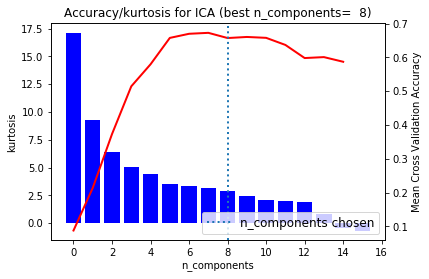

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [18]:
########################################################################################################################
########################################################################################################################
#Dimensionality reduction ICA
#kurtosis calculation

print("Starting ICA")
print("Dimensionality reduction")

def _calculate(X, ica_, n_components):
    
    components = ica_.components_
    ica_.components_ = components[:n_components]

    transformed = ica_.transform(X)
    ica_.components_ = components
 
    kurtosis = scipy.stats.kurtosis(transformed)

    return sorted(kurtosis, reverse = True)	



decisiontree = DecisionTreeClassifier(criterion = 'gini', max_depth = 15, min_samples_split = 5)
ica = FastICA()

pipe = Pipeline(steps=[('ica', ica), ('decisionTree', decisiontree)])

# Plot the ICA spectrum
ica.fit(X)

fig, ax = plt.subplots()
ax.bar(np.arange(X.shape[1]), _calculate(X,ica, X.shape[1]) , linewidth=2, color = 'blue')


plt.axis('tight')
plt.xlabel('n_components')
ax.set_ylabel('kurtosis')

#Checking the accuracy for taking all combination of components
n_components = range(1, X.shape[1])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
gridSearch = GridSearchCV(pipe, dict(ica__n_components=n_components), cv = 3)
gridSearch.fit(X, y)
results = gridSearch.cv_results_
ax1 = ax.twinx()

#Plotting the accuracies and best component
ax1.plot(results['mean_test_score'], linewidth = 2, color = 'red')
ax1.set_ylabel('Mean Cross Validation Accuracy')
ax1.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)

plt.legend(prop=dict(size=12))
plt.title('Accuracy/kurtosis for ICA (best n_components=  %d)'%gridSearch.best_estimator_.named_steps['ica'].n_components )
plt.show()


#Reducing the dimensions with optimal number of components
ica_new = FastICA(n_components = gridSearch.best_estimator_.named_steps['ica'].n_components)
ica_new.fit(X_train)
X_train_transformed = ica_new.transform(X_train)
X_test_transformed = ica_new.transform(X_test)


Calculating Reconstruction Error


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tole

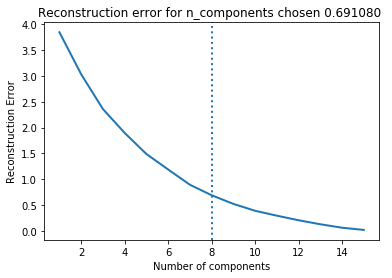

In [19]:

###############################################################################################################################
#Reconstruction Error

print("Calculating Reconstruction Error")


reconstruction_error = []
for comp in n_components:

	ica = FastICA(n_components = comp)
	X_transformed = ica.fit_transform(X_train)
	X_projected = ica.inverse_transform(X_transformed)
	reconstruction_error.append(((X_train - X_projected) ** 2).mean())

	if(comp == gridSearch.best_estimator_.named_steps['ica'].n_components):
		chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
ax2.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen %f '%chosen_error)
plt.show()


Clustering ICA
Expected Maximization


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice.
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

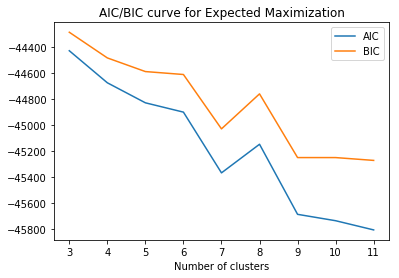

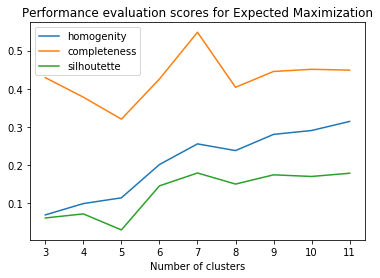

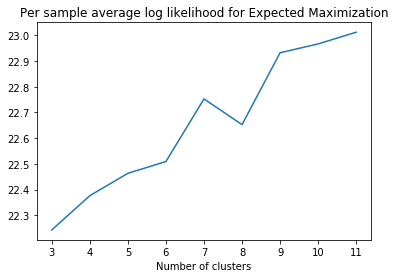

In [23]:
################################################################################################################################
#Dimensionally reduce the full dataset
#Reducing the dimensions with optimal number of components
ica_new = FastICA(n_components = gridSearch.best_estimator_.named_steps['ica'].n_components)
ica_new.fit(X_f)
X_transformed_f = ica_new.transform(X_f)


#Clustering after dimensionality reduction
print("Clustering ICA")


means_init = np.array([X_transformed_f[y_f == i].mean(axis=0) for i in range(7)])

#clustering experiments
print("Expected Maximization")
component_list, array_aic, array_bic, array_homo_1, array_comp_1, array_sil_1, array_avg_log = em(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 26, toshow =0)

print("KMeans")
component_list, array_homo_2, array_comp_2, array_sil_2, array_var = kmeans(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 26, toshow = 0)

